In [22]:
import os
import pandas as pd

from QEDV_lib import QuantumError

# Base folder containing the numbered subfolders
base_folder = "/mnt/c/Users/Ryan/Desktop/QEDV/testout"

# List to store dataframes
dfs = []

# Loop through folders 1-10
for i in range(11, 16):
    # folder_path = os.path.join(base_folder, str(i))
    folder_path = base_folder
    # Check if folder exists
    if os.path.isdir(folder_path):
        # Loop through all .pkl files in the folder
        for file in os.listdir(folder_path):
            if file.endswith(".pkl"):
                file_path = os.path.join(folder_path, file)
                df = pd.read_pickle(file_path)  # Read the pickle file
                dfs.append(df)

# Concatenate all dataframes
if dfs:
    final_df = pd.concat(dfs, ignore_index=True)
    print(final_df)
else:
    print("No pickle files found.")

        Error Rate  Dimension  Solvable    rlimit          time  Brute  \
0            0.001          0      True         0  3.638999e-06  False   
1            0.001          0      True         0  7.039998e-07  False   
2            0.001          0      True         0  3.810001e-07  False   
3            0.001          0      True         0  3.499999e-07  False   
4            0.001          0      True         0  4.450003e-07  False   
...            ...        ...       ...       ...           ...    ...   
134995       0.500          1     False  79097494  2.109657e-01  False   
134996       0.500          1     False  79156801  2.287966e-01  False   
134997       0.500          1     False  79209076  2.374876e-01  False   
134998       0.500          1     False  79259115  2.167784e-01  False   
134999       0.500          1     False  79310242  2.452435e-01  False   

        BruteTime                                        trials_test  \
0               0  <QEDV_lib.quantum_er

In [23]:
df = final_df

In [25]:
# Extract number of qubits from the trials_test object
df["num_qubits"] = df["trials_test"].apply(lambda x: len(x.qubits) if hasattr(x, "qubits") else None)
# Remove rows where num_qubits is 0
df = df[df["num_qubits"] != 0]

# Reset index after filtering (optional)
df = df.reset_index(drop=True)

# Verify that no zero values remain
print(df["num_qubits"].unique())  # Should not contain 0

# Compute correlation between num_qubits and time
correlation = df["num_qubits"].corr(df["time"])
print("Correlation between number of errors and time:", correlation)


[  1   2   3   4   5   7   6   8   9  11  12  17  10  14  15  13  18  21
  16  20  19  26  23  25  24  22  28  44  40  36  45  50  48  43  47  49
  35  42  39  41  46  37  29  32  38  52  33  34  27  31  30  56  65  72
  63  62  75  57  67  77  61  66  68  64  54  76  60  73  59  74  58  53
  70  79  55  78  84  51  71  80  69  93  92  86 102  95 104  91 105 108
  88 100  97 103  90  98  87  96  94  89 106 113  85 101  99  81 110 107
  83 115 114  82 109 111 121 112 117 119]
Correlation between number of errors and time: 0.4980948153428981


In [13]:
df.groupby("Error Rate")['time'].mean()

Error Rate
0.001    0.353878
0.010    0.259679
0.050    0.231734
0.100    0.226437
0.200    0.223673
0.250    0.222771
0.300    0.227242
0.350    0.224315
0.500    0.221702
Name: time, dtype: float64

In [5]:
import numpy as np
def calcDifficulty(error, len):
    matrix = np.zeros((len,len))
    for qubit in error.qubits:
        row = qubit % len
        col = qubit // len
        matrix[row][col] = 1
    n = len
    
    if n == 0: return []
    
    # Directions for up, down, left, right, and diagonals
    directions = [(-1, 0), (1, 0), (0, -1), (0, 1),   # Up, Down, Left, Right
                  (-1, -1), (-1, 1), (1, -1), (1, 1)]  # Diagonals
    
    visited = [[False] * n for _ in range(n)]
    chains = []  # To store the lengths of all chains

    def dfs(x, y):
        stack = [(x, y)]
        visited[x][y] = True
        length = 1  # Count the initial 1
        
        while stack:
            cx, cy = stack.pop()
            for dx, dy in directions:
                nx, ny = cx + dx, cy + dy
                # Check if the neighbor is within bounds and a 1 that hasn't been visited
                if 0 <= nx < n and 0 <= ny < n and not visited[nx][ny] and matrix[nx][ny] == 1:
                    visited[nx][ny] = True
                    stack.append((nx, ny))
                    length += 1
        return length

    # Traverse all cells in the matrix
    for i in range(n):
        for j in range(n):
            if matrix[i][j] == 1 and not visited[i][j]:
                # Run DFS to find the chain length
                chain_length = dfs(i, j)
                chains.append(chain_length)

    return chains

In [6]:
from QEDV_lib import QuantumError
matrix = [
    [1, 0, 1, 1],
    [1, 1, 0, 0],
    [0, 1, 1, 1],
    [0, 0, 1, 1]
]

calcDifficulty(QuantumError({1,2,8}),3)  # Output: 5 (longest connected chain of 1’s)


[2, 1]

In [7]:
 def getDiff(trial_test, trial_dim):
    # Example implementation (adjust based on your actual function)
    lis = calcDifficulty(trial_test, trial_dim)
    sum = 0
    for entry in lis:
        sum += entry**2
    return sum

def maxLength(trials_test, trials_dim):
    result = calcDifficulty(trials_test, trials_dim)
    if result:
        return max(result)
    return 0
# Track progress during apply()
def getDiff_with_progress(row, index, total):
    if index % 100 == 0:  # Print progress every 100 rows
        print(f"Processing row {index}/{total}...")
    return getDiff(row['trials_test'], row['trial_dim'])

def maxLength_with_progress(row, index, total):
    if index % 100 == 0:
        print(f"Processing row {index}/{total}...")
    return maxLength(row['trials_test'], row['trial_dim'])

total_rows = len(df)

df['diff'] = [getDiff_with_progress(row, i, total_rows) for i, row in df.iterrows()]
df['diff_2'] = [maxLength_with_progress(row, i, total_rows) for i, row in df.iterrows()]



Processing row 0/693920...
Processing row 100/693920...
Processing row 200/693920...
Processing row 300/693920...
Processing row 400/693920...
Processing row 500/693920...
Processing row 600/693920...
Processing row 700/693920...
Processing row 800/693920...
Processing row 900/693920...
Processing row 1000/693920...
Processing row 1100/693920...
Processing row 1200/693920...
Processing row 1300/693920...
Processing row 1400/693920...
Processing row 1500/693920...
Processing row 1600/693920...
Processing row 1700/693920...
Processing row 1800/693920...
Processing row 1900/693920...
Processing row 2000/693920...
Processing row 2100/693920...
Processing row 2200/693920...
Processing row 2300/693920...
Processing row 2400/693920...
Processing row 2500/693920...
Processing row 2600/693920...
Processing row 2700/693920...
Processing row 2800/693920...
Processing row 2900/693920...
Processing row 3000/693920...
Processing row 3100/693920...
Processing row 3200/693920...
Processing row 3300/69

In [8]:
correlation = df['diff'].corr(df['time'])
correlation2 = df['diff_2'].corr(df['time'])

print("With length of chain squared", correlation, "With max length", correlation2)

With length of chain squared 0.2726569552210108 With max length 0.26189032439885446


In [21]:
corr = df['time'].corr(df['trial_dim'])
corr

0.9327616534261558

In [22]:
df['trial_dim'].unique()


array([0, 1])

In [23]:
df.groupby('trial_dim')[['time','num_qubits']].corr().unstack().iloc[:,1]


trial_dim
0    0.005353
1    0.011651
Name: (time, num_qubits), dtype: float64

In [24]:
# Compute overall correlation (without grouping)
overall_corr_diff = df["diff"].corr(df["time"])
overall_corr_diff2 = df["diff_2"].corr(df["time"])
overall_corr_qubits = df["num_qubits"].corr(df["time"])

print("Overall Correlation:")
print("diff vs. time:", overall_corr_diff)
print("diff_2 vs. time:", overall_corr_diff2)
print("num_qubits vs. time:", overall_corr_qubits)


KeyError: 'diff'

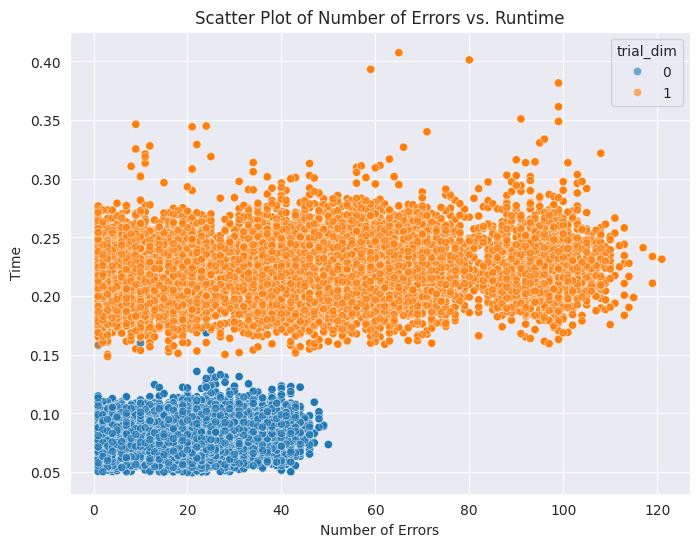

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df["num_qubits"], y=df["time"], hue=df["trial_dim"], alpha=0.6)

# Add labels and title
plt.xlabel("Number of Errors")
plt.ylabel("Runtime")
plt.title("Number of Errors vs. Runtime")

# Show the plot
plt.show()


In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df["num_qubits"], y=df["diff"], hue=df["time"], alpha=0.6)

# Add labels and title
plt.xlabel("Number of Qubits")
plt.ylabel("Difficulty")
plt.title("Scatter Plot of Number of Qubits vs. Time")

# Show the plot
plt.show()


KeyError: 'diff'

<Figure size 800x600 with 0 Axes>

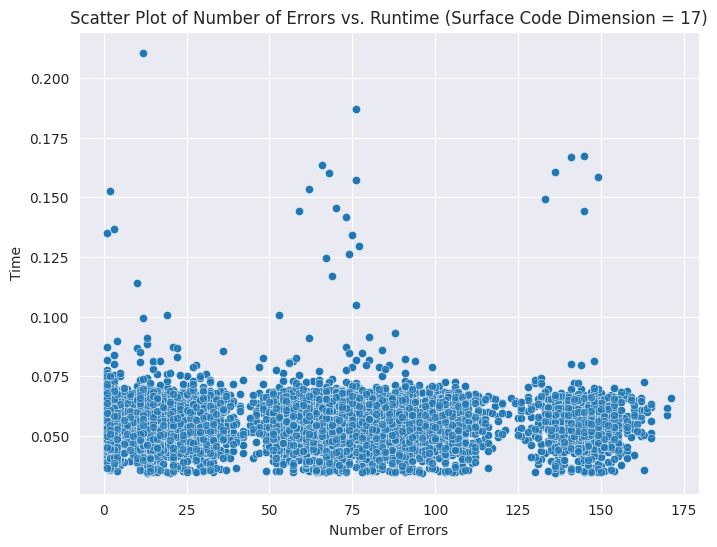

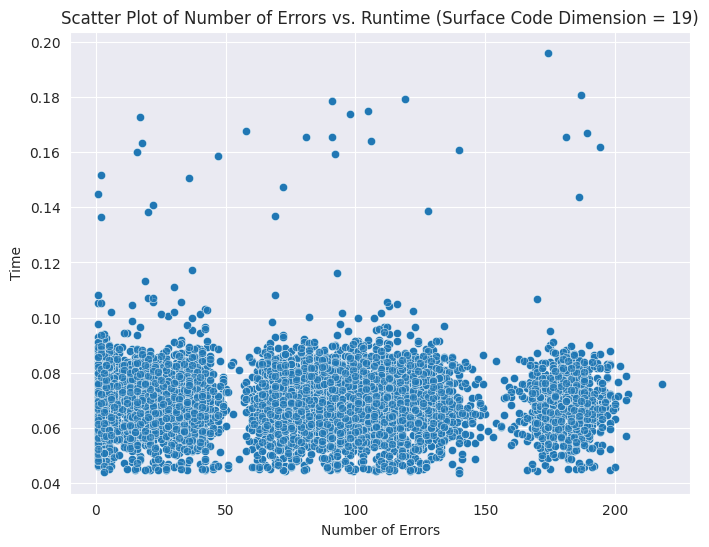

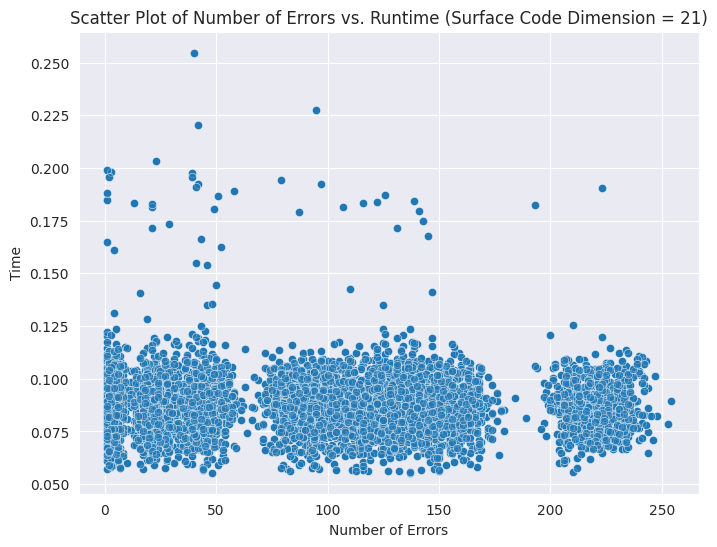

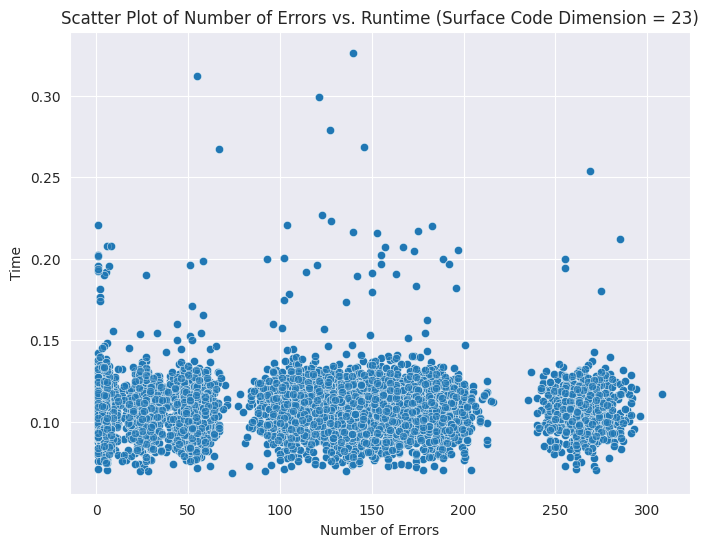

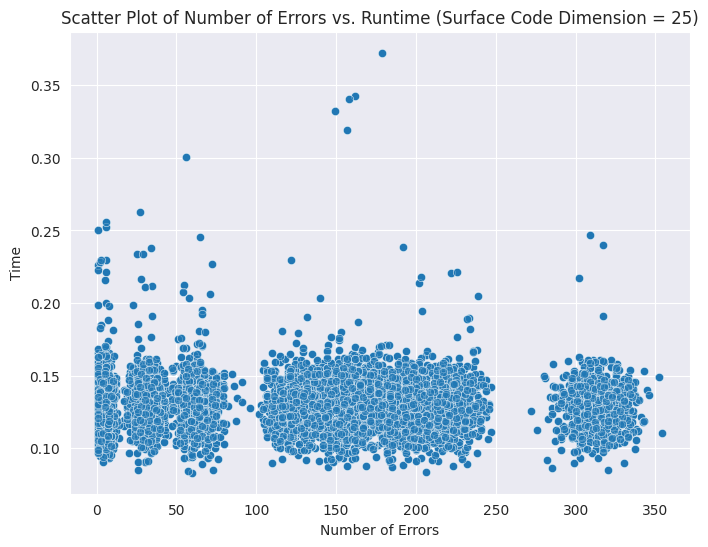

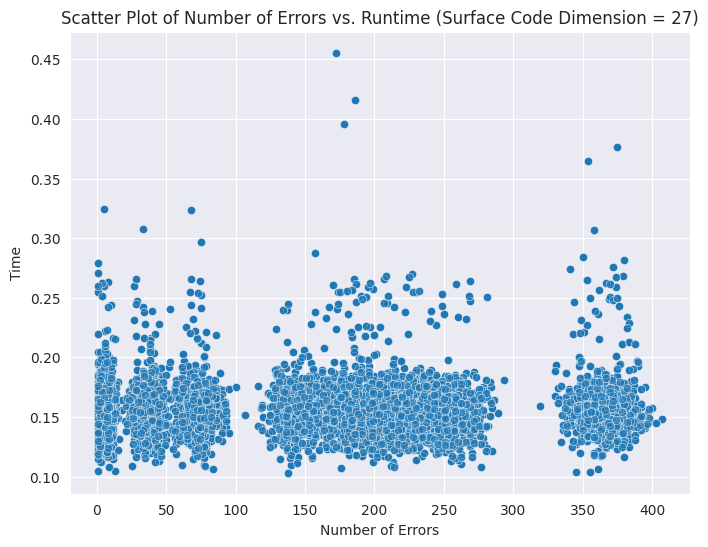

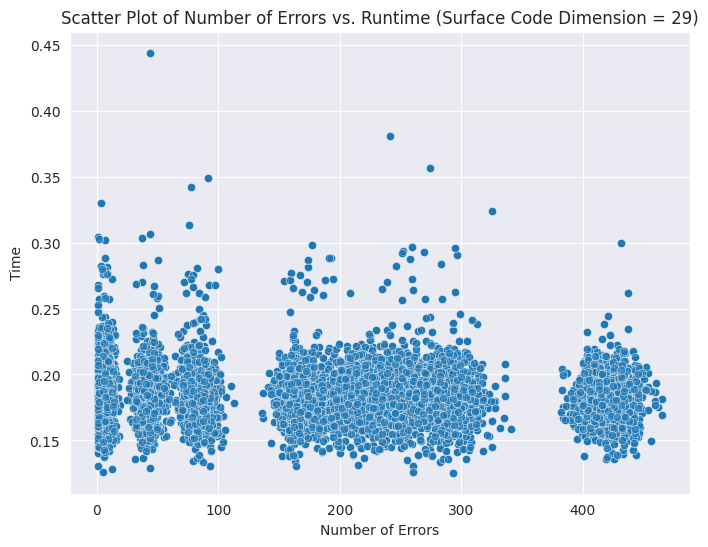

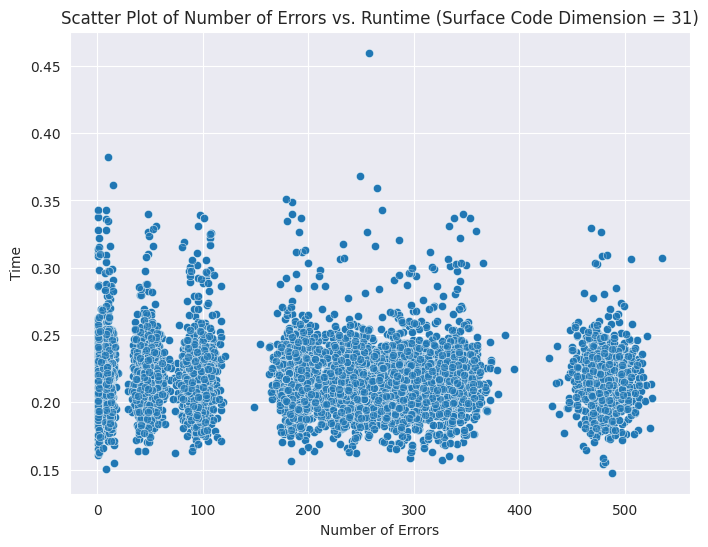

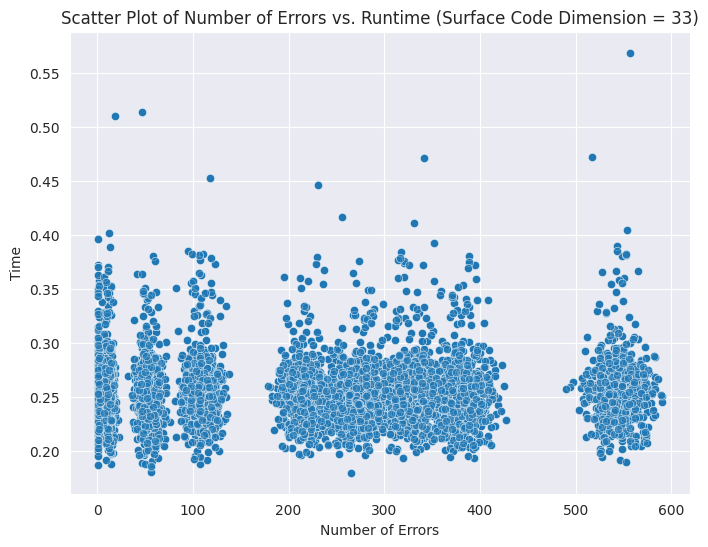

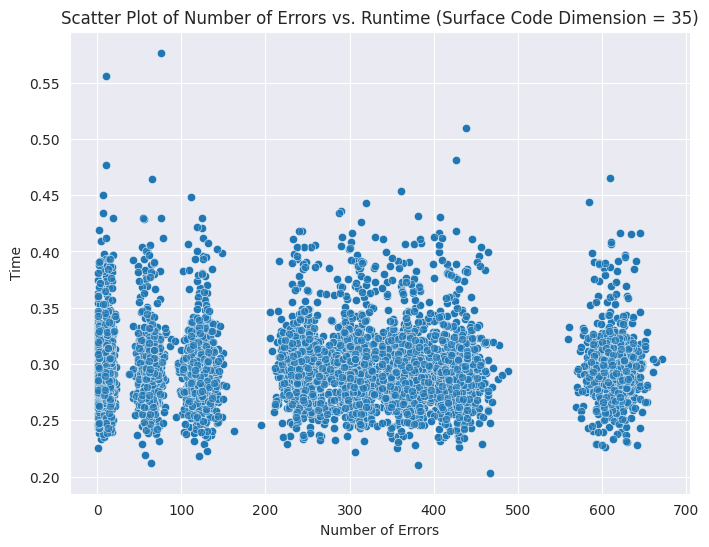

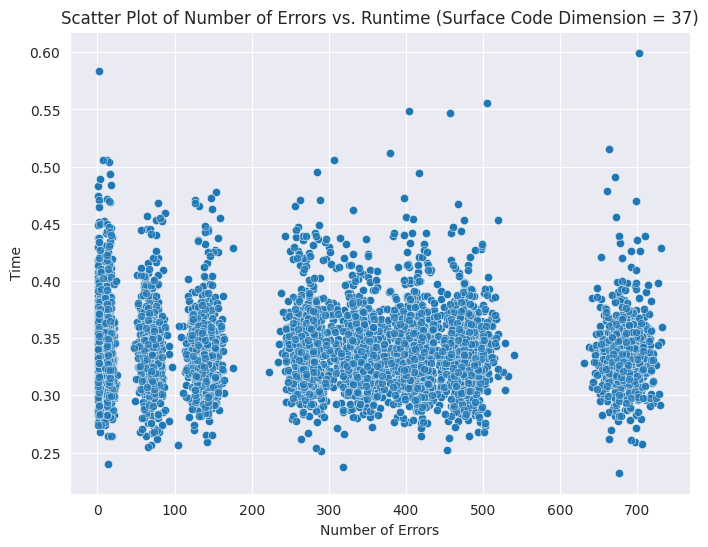

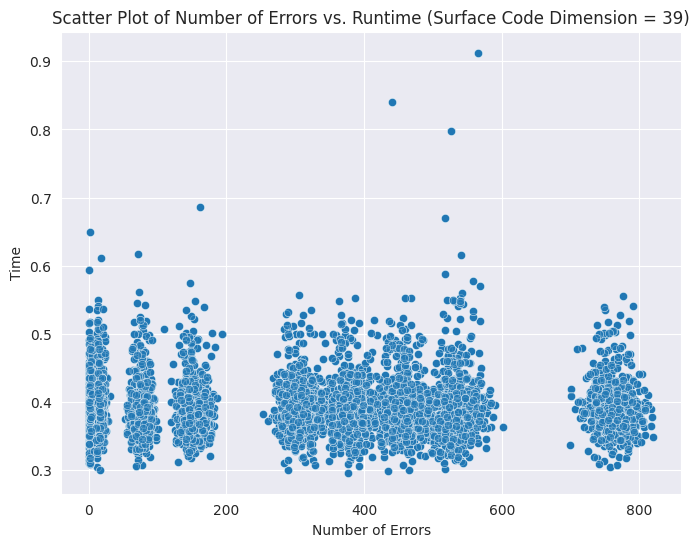

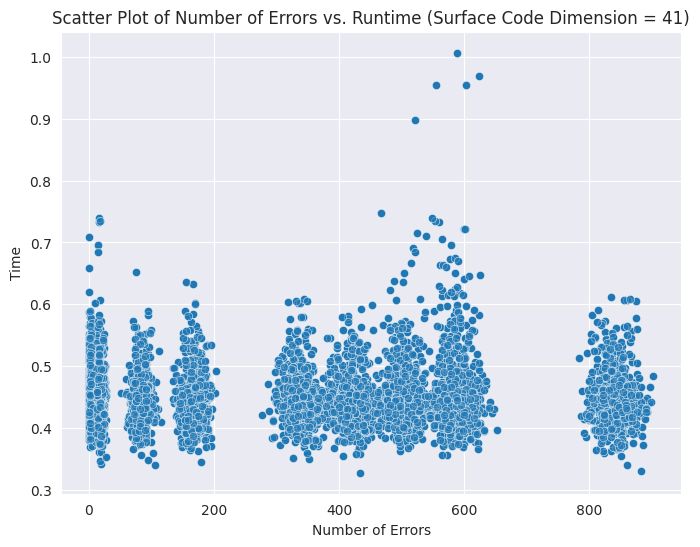

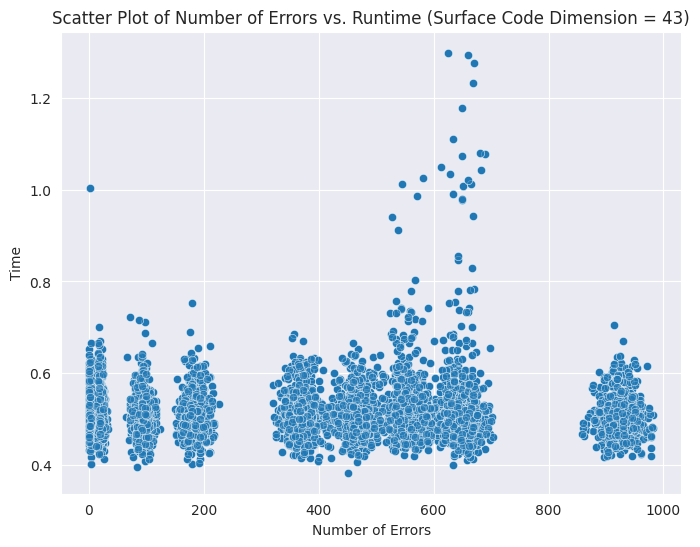

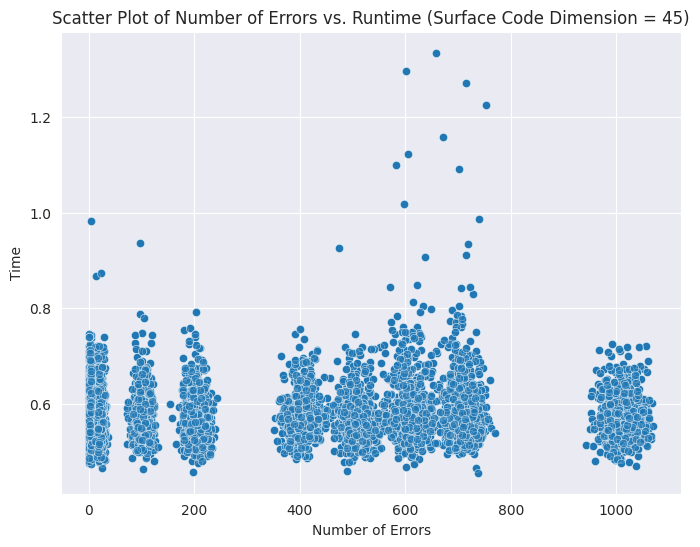

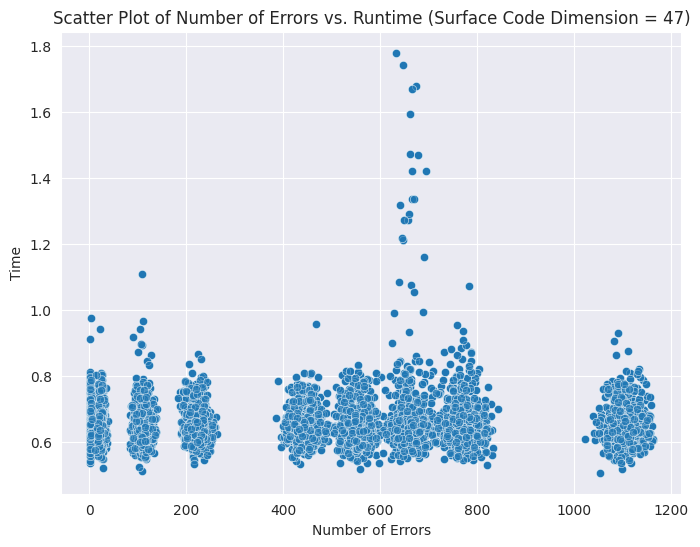

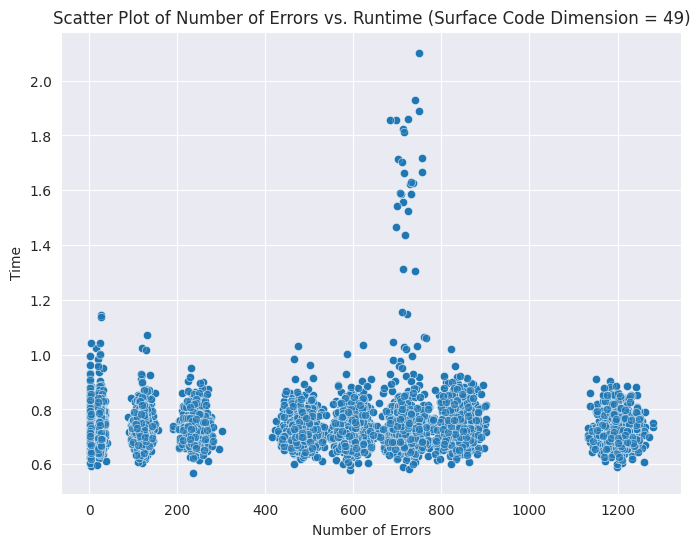

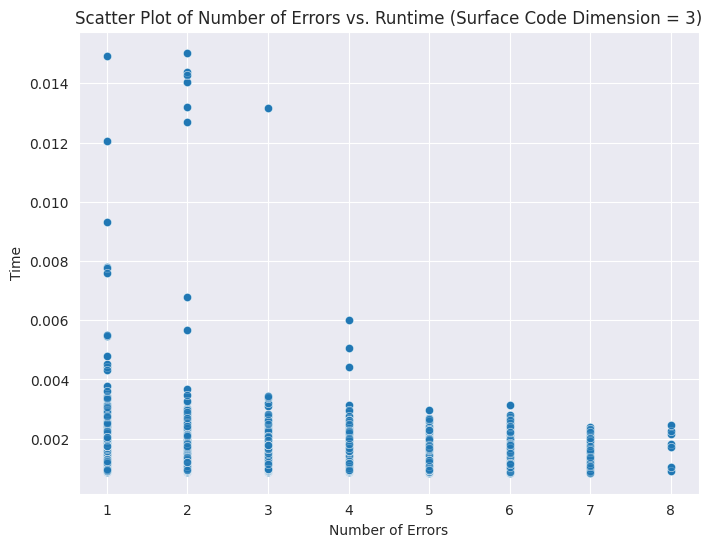

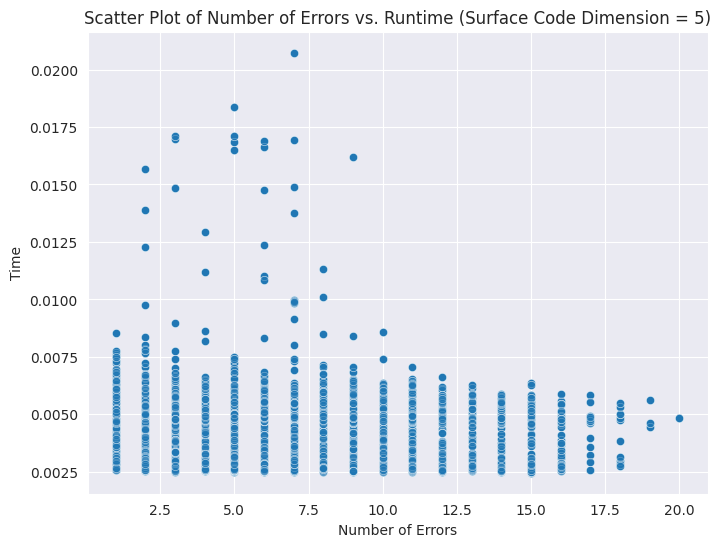

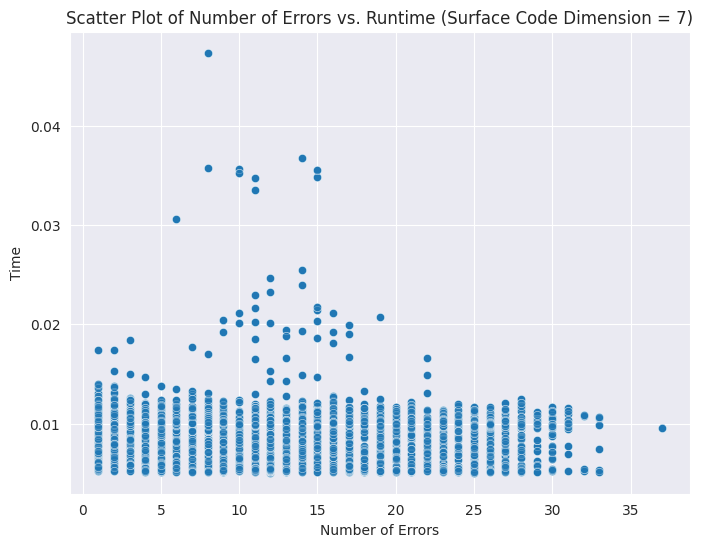

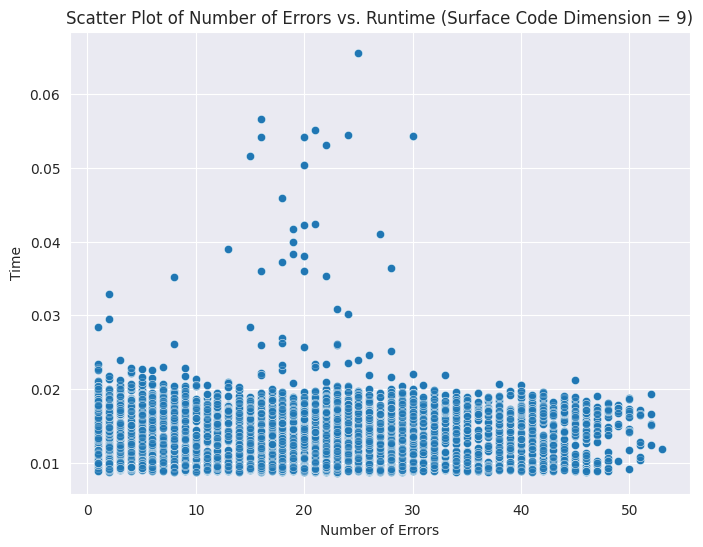

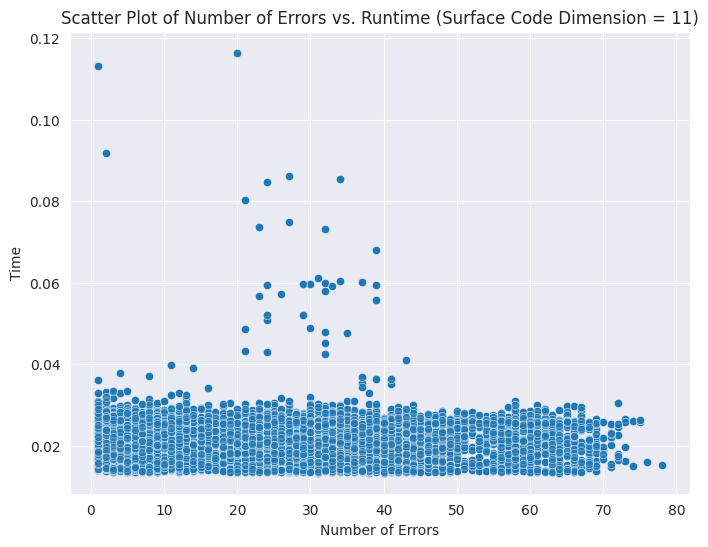

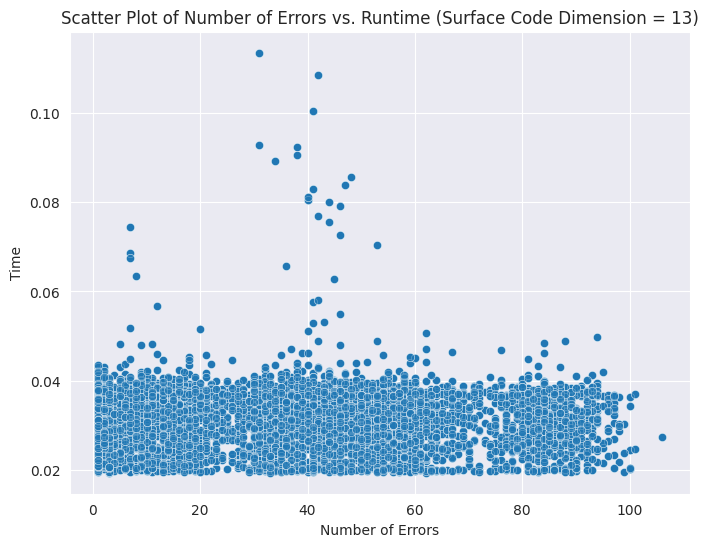

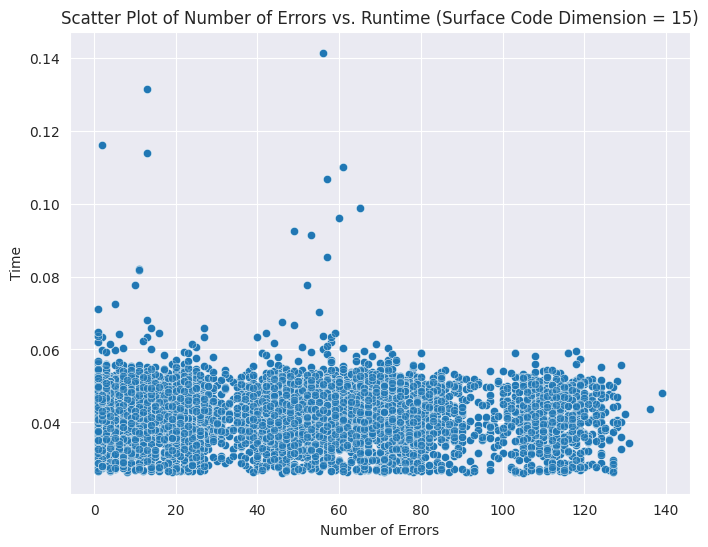

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define the specific trial_dim value you want to plot
selected_trial_dims = df['trial_dim'].unique()


for trial_dim_value in selected_trial_dims:
    # Filter the DataFrame for the specific trial_dim
    df_filtered = df[df["trial_dim"] == trial_dim_value]

    # Create scatter plot
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=df_filtered["num_qubits"], y=df_filtered["time"], alpha=0.6)

    # Add labels and title
    plt.xlabel("Number of Errors")
    plt.ylabel("Time")
    plt.title(f"Scatter Plot of Number of Errors vs. Runtime (Surface Code Dimension = {trial_dim_value})")

    # Show the plot
    plt.show()


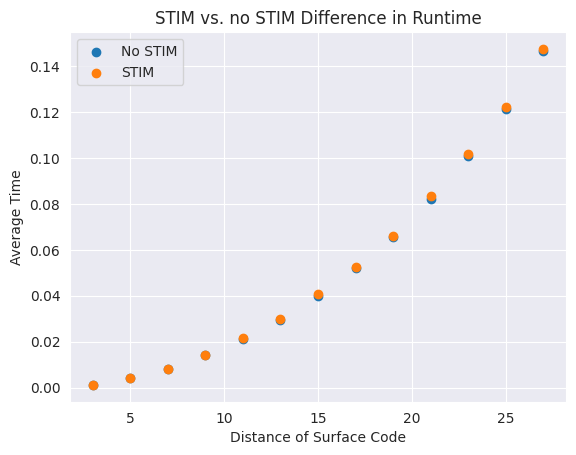

In [9]:
import matplotlib.pyplot as plt
df_avg = df.groupby('trial_dim', as_index=False)[['time', 'time2']].mean()

# Plot
plt.scatter(df_avg['trial_dim'], df_avg['time'], label='No STIM')
plt.scatter(df_avg['trial_dim'], df_avg['time2'], label='STIM')

# Labels
plt.xlabel('Distance of Surface Code')
plt.ylabel('Average Time')
# plt.hue(df[""])
plt.title('STIM vs. no STIM Difference in Runtime')
plt.legend()

plt.grid(True)
plt.show()
